In [2]:
from tensorflow.python.client import device_lib 
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6292355221577899689
 xla_global_id: -1]

In [1]:
import pandas as pd
import os
import matplotlib as mpl
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
print(mpl.__version__)
# seaborn 스타일 사용
plt.style.use('seaborn-notebook')

# matplotlib 그래프 한글폰트 깨질 때 대처(Mac & Window)
import platform
if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')
    
# 그래프에서 마이너스 기호가 표시되도록 하는 설정
mpl.rcParams['axes.unicode_minus'] = False

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


3.4.3


In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

train_X = train.drop('Target', axis=1)
train_y = train.Target

In [8]:
train_X = pd.get_dummies(data = train_X, columns = ['Gender'], prefix = 'Gender')
test = pd.get_dummies(data = test, columns = ['Gender'], prefix = 'Gender')

In [46]:
train_X

,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Gender_F,Gender_I,Gender_M
0,0.605,0.470,0.115,1.1140,0.3925,0.2910,0.3100,0,0,1
1,0.430,0.315,0.095,0.3780,0.1750,0.0800,0.1045,0,1,0
2,0.580,0.490,0.195,1.3165,0.5305,0.2540,0.4100,0,1,0
3,0.535,0.405,0.175,1.2705,0.5480,0.3265,0.3370,0,0,1
4,0.310,0.235,0.090,0.1270,0.0480,0.0310,0.0400,0,1,0
...,...,...,...,...,...,...,...,...,...,...
1248,0.190,0.145,0.040,0.0380,0.0165,0.0065,0.0150,0,1,0
1249,0.395,0.310,0.085,0.3170,0.1530,0.0505,0.0935,0,1,0
1250,0.525,0.410,0.115,0.7745,0.4160,0.1630,0.1800,1,0,0
1251,0.445,0.335,0.110,0.4355,0.2025,0.1095,0.1195,1,0,0


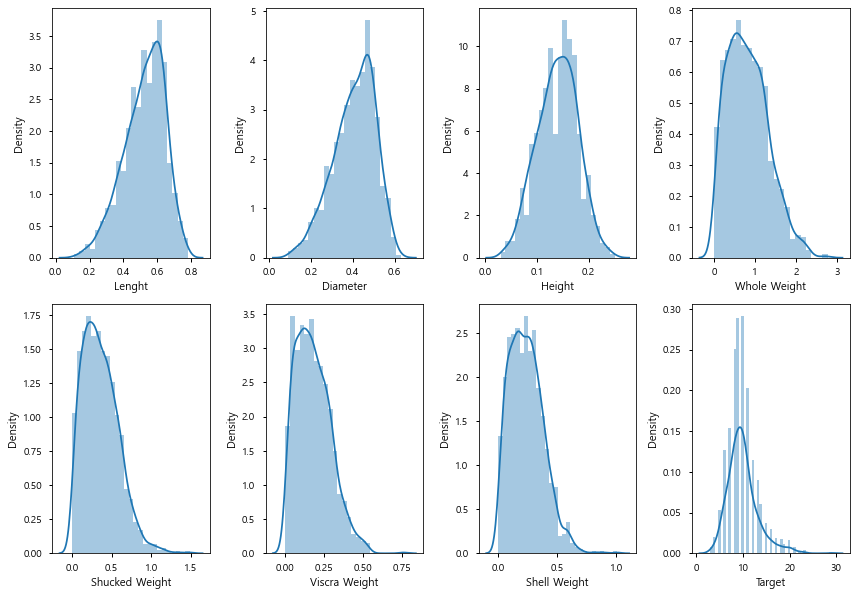

In [3]:
plt.figure(figsize=(12,12))
for i in range(1,9):
    plt.subplot(3,4,i)
    sns.distplot(train.iloc[:,i])
plt.tight_layout()
plt.show()

<AxesSubplot:>

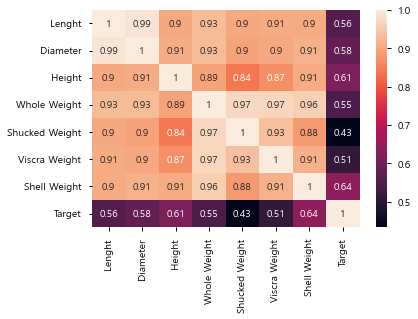

In [313]:
sns.heatmap(train.corr(), annot = True)

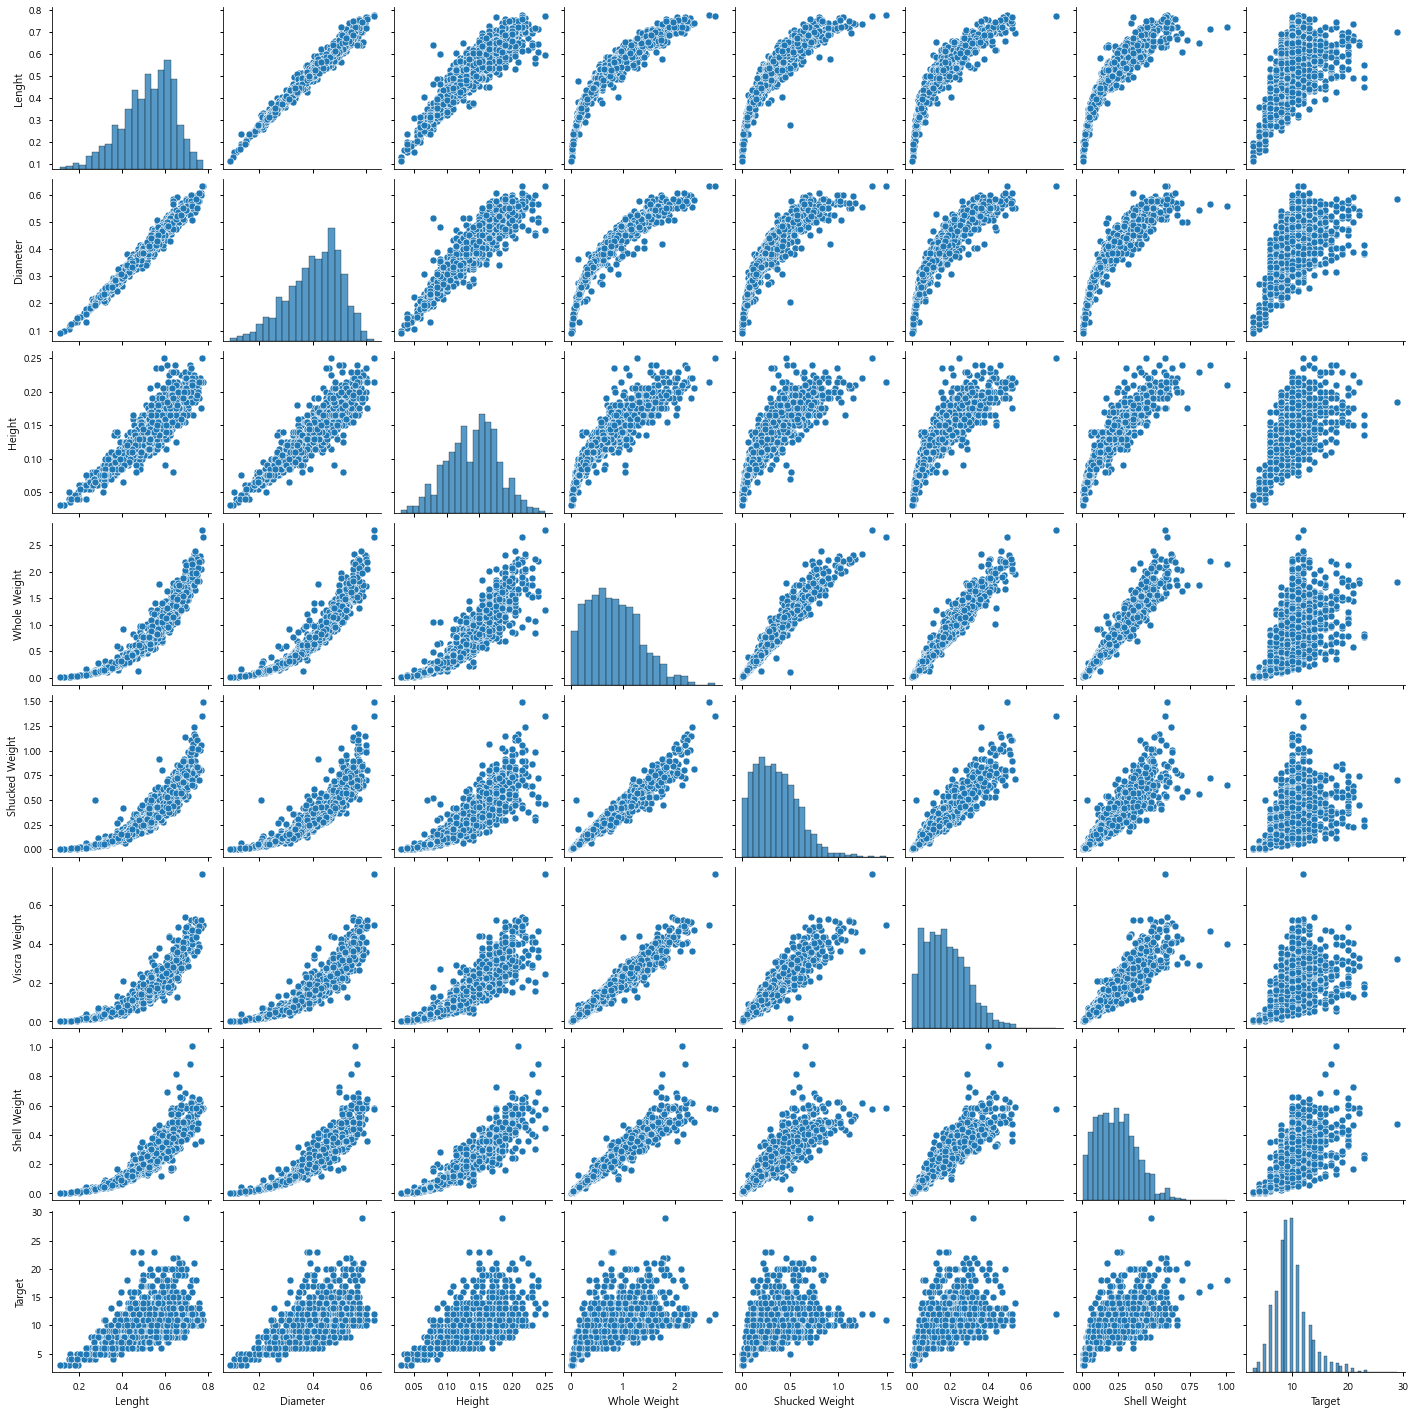

In [4]:
sns.pairplot(train)

# 파이캐럿 (전처리 X)

In [ ]:
pycaret_data = pd.get_dummies(data = train, columns = ['Gender'], prefix = 'Gender')

In [ ]:
from pycaret.classification import *
from pycaret.regression import *

In [ ]:
setup_clf = setup(data = pycaret_data, target = 'Target', fold_shuffle=True, use_gpu=True, silent=True)

In [ ]:
top10 = compare_models(sort='MAE', n_select=10, fold = 5)

In [ ]:
tuned_top10 = [tune_model(i, fold = 5) for i in top10]

In [ ]:
blender_top10 = blend_models(estimator_list=tuned_top10)

In [ ]:
final_model = finalize_model(blender_top10)
prediction = predict_model(final_model, data= test)

In [ ]:
prediction

In [ ]:
prediction['Label']

In [ ]:
submission = pd.read_csv('sample_submission.csv')

submission['Target'] = prediction['Label']

submission

submission.to_csv('submission.csv',index=False)

# 딥러닝 기반

In [3]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

In [43]:
# 딥러닝 모델 선언
model = Sequential()
model.add(Dense(16, input_dim=10, activation='elu'))
model.add(Dense(32, activation='elu'))    
model.add(Dense(64, activation='elu'))  
model.add(Dropout(0.5))  
model.add(Dense(32, activation='elu'))
model.add(Dense(16, activation='elu'))
model.add(Dense(1))


model.compile(loss='mean_absolute_error',
              optimizer='Nadam', 
              metrics=['mae'])

In [44]:
# 모델 저장 폴더 만들기
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = "./model/{epoch:02d}-{val_loss:.4f}.hdf5"

# 모델 업데이트 및 저장
cp = ModelCheckpoint(filepath=modelpath, monitor='val_mae', verbose=0, save_best_only=True, mode = 'min')

# 학습 자동 중단 설정
es = EarlyStopping(monitor='val_mae', patience=50, mode='min')

rlrp = ReduceLROnPlateau(monitor='val_mae', factor=0.2, patience=45, mode='min')

In [45]:
# 모델 학습
model.fit(train_X, train_y, validation_split=0.3, epochs=1000, batch_size=32, verbose=1, callbacks=[es, cp, rlrp])

Epoch 1/1000
28/28 [==============================] - 1s 6ms/step - loss: 7.5609 - mae: 7.5609 - val_loss: 3.0594 - val_mae: 3.0594 - lr: 0.0010
Epoch 2/1000
28/28 [==============================] - 0s 3ms/step - loss: 2.1725 - mae: 2.1725 - val_loss: 1.9832 - val_mae: 1.9832 - lr: 0.0010
Epoch 3/1000
28/28 [==============================] - 0s 3ms/step - loss: 1.9480 - mae: 1.9480 - val_loss: 1.9483 - val_mae: 1.9483 - lr: 0.0010
Epoch 4/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.8996 - mae: 1.8996 - val_loss: 1.9529 - val_mae: 1.9529 - lr: 0.0010
Epoch 5/1000
28/28 [==============================] - 0s 3ms/step - loss: 1.9051 - mae: 1.9051 - val_loss: 1.9316 - val_mae: 1.9316 - lr: 0.0010
Epoch 6/1000
28/28 [==============================] - 0s 3ms/step - loss: 1.8201 - mae: 1.8201 - val_loss: 1.9283 - val_mae: 1.9283 - lr: 0.0010
Epoch 7/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.8132 - mae: 1.8132 - val_loss: 1.9365 - val_mae: 1.936

28/28 [==============================] - 0s 2ms/step - loss: 1.4810 - mae: 1.4810 - val_loss: 1.5998 - val_mae: 1.5998 - lr: 0.0010
Epoch 114/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4435 - mae: 1.4435 - val_loss: 1.6283 - val_mae: 1.6283 - lr: 0.0010
Epoch 115/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4554 - mae: 1.4554 - val_loss: 1.6222 - val_mae: 1.6222 - lr: 0.0010
Epoch 116/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4803 - mae: 1.4803 - val_loss: 1.6243 - val_mae: 1.6243 - lr: 0.0010
Epoch 117/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4670 - mae: 1.4670 - val_loss: 1.6426 - val_mae: 1.6426 - lr: 0.0010
Epoch 118/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4533 - mae: 1.4533 - val_loss: 1.6052 - val_mae: 1.6052 - lr: 0.0010
Epoch 119/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4483 - mae: 1.4483 - val_loss: 1.6014 - val_mae: 1.6014

Epoch 169/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4516 - mae: 1.4516 - val_loss: 1.5593 - val_mae: 1.5593 - lr: 0.0010
Epoch 170/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4426 - mae: 1.4426 - val_loss: 1.5519 - val_mae: 1.5519 - lr: 0.0010
Epoch 171/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4400 - mae: 1.4400 - val_loss: 1.5631 - val_mae: 1.5631 - lr: 0.0010
Epoch 172/1000
28/28 [==============================] - 0s 3ms/step - loss: 1.4414 - mae: 1.4414 - val_loss: 1.5502 - val_mae: 1.5502 - lr: 0.0010
Epoch 173/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4294 - mae: 1.4294 - val_loss: 1.5918 - val_mae: 1.5918 - lr: 0.0010
Epoch 174/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4365 - mae: 1.4365 - val_loss: 1.5561 - val_mae: 1.5561 - lr: 0.0010
Epoch 175/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4078 - mae: 1.4078 - val_loss: 1.5564 - 

Epoch 225/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4066 - mae: 1.4066 - val_loss: 1.5423 - val_mae: 1.5423 - lr: 0.0010
Epoch 226/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4164 - mae: 1.4164 - val_loss: 1.5482 - val_mae: 1.5482 - lr: 0.0010
Epoch 227/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4228 - mae: 1.4228 - val_loss: 1.5698 - val_mae: 1.5698 - lr: 0.0010
Epoch 228/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4096 - mae: 1.4096 - val_loss: 1.5450 - val_mae: 1.5450 - lr: 0.0010
Epoch 229/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4348 - mae: 1.4348 - val_loss: 1.5867 - val_mae: 1.5867 - lr: 0.0010
Epoch 230/1000
28/28 [==============================] - 0s 3ms/step - loss: 1.4356 - mae: 1.4356 - val_loss: 1.5406 - val_mae: 1.5406 - lr: 0.0010
Epoch 231/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4264 - mae: 1.4264 - val_loss: 1.5603 - 

Epoch 281/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4098 - mae: 1.4098 - val_loss: 1.5495 - val_mae: 1.5495 - lr: 0.0010
Epoch 282/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4141 - mae: 1.4141 - val_loss: 1.5374 - val_mae: 1.5374 - lr: 0.0010
Epoch 283/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.3956 - mae: 1.3956 - val_loss: 1.5363 - val_mae: 1.5363 - lr: 0.0010
Epoch 284/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4062 - mae: 1.4062 - val_loss: 1.5321 - val_mae: 1.5321 - lr: 0.0010
Epoch 285/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4147 - mae: 1.4147 - val_loss: 1.5474 - val_mae: 1.5474 - lr: 0.0010
Epoch 286/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.3918 - mae: 1.3918 - val_loss: 1.5324 - val_mae: 1.5324 - lr: 0.0010
Epoch 287/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4067 - mae: 1.4067 - val_loss: 1.5865 - 

Epoch 337/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.3932 - mae: 1.3932 - val_loss: 1.5454 - val_mae: 1.5454 - lr: 0.0010
Epoch 338/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.3955 - mae: 1.3955 - val_loss: 1.5419 - val_mae: 1.5419 - lr: 0.0010
Epoch 339/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.3934 - mae: 1.3934 - val_loss: 1.5343 - val_mae: 1.5343 - lr: 0.0010
Epoch 340/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4160 - mae: 1.4160 - val_loss: 1.5464 - val_mae: 1.5464 - lr: 0.0010
Epoch 341/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4041 - mae: 1.4041 - val_loss: 1.5458 - val_mae: 1.5458 - lr: 0.0010
Epoch 342/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.3771 - mae: 1.3771 - val_loss: 1.5386 - val_mae: 1.5386 - lr: 2.0000e-04
Epoch 343/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.3907 - mae: 1.3907 - val_loss: 1.530

In [21]:
Y_prediction = model.predict(test).flatten()

In [22]:
Y_prediction

array([ 8.929717, 14.675825,  5.293755, ...,  9.04725 ,  8.42572 ,
       12.411996], dtype=float32)

In [39]:
submission = pd.read_csv('sample_submission.csv')

submission['Target'] = np.round(Y_prediction)

submission

submission.to_csv('submission.csv',index=False)

# Kfold

In [57]:
from sklearn.model_selection import StratifiedKFold

In [197]:
skf = StratifiedKFold(n_splits = 10, random_state = 123, shuffle = True)

In [198]:
es = EarlyStopping(monitor='val_mae', patience=50, mode='min')
rlrp = ReduceLROnPlateau(monitor='val_mae', factor=0.2, patience=45, mode='min')

In [199]:
nn_val_mae = []
nn_pred = np.array([0.0]*2924)
for i, (tr_idx, val_idx) in enumerate(skf.split(train_X, train_y)) :
    print(f'{i + 1} Fold Training.....')
    tr_x, tr_y = train_X.iloc[tr_idx], train_y[tr_idx]
    val_x, val_y = train_X.iloc[val_idx], train_y[val_idx]
    
    ### NN 모델
    model = Sequential()
    model.add(Dense(16, input_dim=10, activation='elu'))
    model.add(Dense(32, activation='elu'))    
    model.add(Dense(64, activation='elu'))            
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='elu'))
    model.add(Dense(16, activation='elu'))
    model.add(Dense(1))

    ### ModelCheckPoint Fold마다 갱신
    cp = ModelCheckpoint(f'model_{i + 1}.h5', save_best_only = True, monitor = 'val_mae', mode = 'min', verbose = 0)
    ### 모델 compile
    model.compile(loss='mean_absolute_error',
                  optimizer='Nadam', 
                  metrics=['mae'])

    result = model.fit(tr_x, tr_y, validation_data = (val_x, val_y), epochs = 1000, batch_size = 32, callbacks = [es, cp, rlrp], verbose = 0)

    ### 최고 성능 기록 모델 Load
    best = load_model(f'model_{i + 1}.h5')
    ### validation predict
    val_pred = best.predict(val_x)
    ### Fold별 val_mae 산출
    fold_val_mae = result.history['val_mae'][-51]
    nn_val_mae.append(fold_val_mae)
    print(f'{i + 1} Fold val mae = {fold_val_mae}\n')

    ### Fold별 test 데이터에 대한 예측값 생성 및 앙상블
    fold_pred = best.predict(test).flatten()
    nn_pred += fold_pred

1 Fold Training.....
1 Fold val mae = 1.4676733016967773

2 Fold Training.....
2 Fold val mae = 1.287061333656311

3 Fold Training.....
3 Fold val mae = 1.5796390771865845

4 Fold Training.....
4 Fold val mae = 1.4758315086364746

5 Fold Training.....
5 Fold val mae = 1.5080046653747559

6 Fold Training.....
6 Fold val mae = 1.4859299659729004

7 Fold Training.....
7 Fold val mae = 1.2347930669784546

8 Fold Training.....
8 Fold val mae = 1.415439486503601

9 Fold Training.....
9 Fold val mae = 1.4209425449371338

10 Fold Training.....
10 Fold val mae = 1.3414922952651978



In [200]:
np.mean(nn_val_mae)

1.4216807246208192

In [137]:
submission = pd.read_csv('sample_submission.csv')

submission['Target'] = nn_pred / skf.n_splits

submission

submission.to_csv('submission.csv',index=False)

# feature 추가

In [214]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

train_X = train.drop('Target', axis=1)
train_y = train.Target

In [215]:
train_X = pd.get_dummies(data = train_X, columns = ['Gender'], prefix = 'Gender')
test = pd.get_dummies(data = test, columns = ['Gender'], prefix = 'Gender')

In [216]:
train_X

,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Gender_F,Gender_I,Gender_M
0,0.605,0.470,0.115,1.1140,0.3925,0.2910,0.3100,0,0,1
1,0.430,0.315,0.095,0.3780,0.1750,0.0800,0.1045,0,1,0
2,0.580,0.490,0.195,1.3165,0.5305,0.2540,0.4100,0,1,0
3,0.535,0.405,0.175,1.2705,0.5480,0.3265,0.3370,0,0,1
4,0.310,0.235,0.090,0.1270,0.0480,0.0310,0.0400,0,1,0
...,...,...,...,...,...,...,...,...,...,...
1248,0.190,0.145,0.040,0.0380,0.0165,0.0065,0.0150,0,1,0
1249,0.395,0.310,0.085,0.3170,0.1530,0.0505,0.0935,0,1,0
1250,0.525,0.410,0.115,0.7745,0.4160,0.1630,0.1800,1,0,0
1251,0.445,0.335,0.110,0.4355,0.2025,0.1095,0.1195,1,0,0


In [217]:
# 전복 전체 무게 대비 불필요한 물질들의 값 ( 이물질 / 핏물 등)
foreign_body = train_X['Whole Weight'] - (train_X['Shucked Weight'] + train_X['Viscra Weight'] + train_X['Shell Weight'])

In [218]:
foreign_body

0       0.1205
1       0.0185
2       0.1220
3       0.0590
4       0.0080
         ...  
1248    0.0000
1249    0.0200
1250    0.0155
1251    0.0040
1252    0.1965
Length: 1253, dtype: float64

In [220]:
foreign_body[47]

-0.06749999999999998

In [221]:
train_X['foreign body'] = foreign_body

In [222]:
#train_X.loc[train_X['foreign body'] < 0 , 'foreign body'] = 0

In [223]:
# 테스트셋에도 적용
foreign_body = test['Whole Weight'] - (test['Shucked Weight'] + test['Viscra Weight'] + test['Shell Weight'])
test['foreign body'] = foreign_body
#test.loc[test['foreign body'] < 0 , 'foreign body'] = 0

In [224]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

In [225]:
# 딥러닝 모델 선언
model = Sequential()
model.add(Dense(16, input_dim=11, activation='elu'))
model.add(Dense(32, activation='elu'))    
model.add(Dense(64, activation='elu'))  
model.add(Dropout(0.5))  
model.add(Dense(32, activation='elu'))
model.add(Dense(16, activation='elu'))
model.add(Dense(1))


model.compile(loss='mean_absolute_error',
              optimizer='Nadam', 
              metrics=['mae'])

In [226]:
# 모델 저장 폴더 만들기
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = "./model/{epoch:02d}-{val_loss:.4f}.hdf5"

# 모델 업데이트 및 저장
cp = ModelCheckpoint(filepath=modelpath, monitor='val_mae', verbose=0, save_best_only=True, mode = 'min')

# 학습 자동 중단 설정
es = EarlyStopping(monitor='val_mae', patience=50, mode='min')

rlrp = ReduceLROnPlateau(monitor='val_mae', factor=0.2, patience=40, mode='min')

In [227]:
# 모델 학습
model.fit(train_X, train_y, validation_split=0.3, epochs=1000, batch_size=32, verbose=1, callbacks=[es, cp, rlrp])

Epoch 1/1000
28/28 [==============================] - 1s 6ms/step - loss: 7.2692 - mae: 7.2692 - val_loss: 3.2520 - val_mae: 3.2520 - lr: 0.0010
Epoch 2/1000
28/28 [==============================] - 0s 3ms/step - loss: 2.1183 - mae: 2.1183 - val_loss: 1.9691 - val_mae: 1.9691 - lr: 0.0010
Epoch 3/1000
28/28 [==============================] - 0s 3ms/step - loss: 1.9239 - mae: 1.9239 - val_loss: 1.9433 - val_mae: 1.9433 - lr: 0.0010
Epoch 4/1000
28/28 [==============================] - 0s 3ms/step - loss: 1.8813 - mae: 1.8813 - val_loss: 1.9253 - val_mae: 1.9253 - lr: 0.0010
Epoch 5/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.8256 - mae: 1.8256 - val_loss: 1.9885 - val_mae: 1.9885 - lr: 0.0010
Epoch 6/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.8194 - mae: 1.8194 - val_loss: 1.9369 - val_mae: 1.9369 - lr: 0.0010
Epoch 7/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.7969 - mae: 1.7969 - val_loss: 1.9253 - val_mae: 1.925

28/28 [==============================] - 0s 2ms/step - loss: 1.4816 - mae: 1.4816 - val_loss: 1.6099 - val_mae: 1.6099 - lr: 0.0010
Epoch 114/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4525 - mae: 1.4525 - val_loss: 1.6223 - val_mae: 1.6223 - lr: 0.0010
Epoch 115/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4613 - mae: 1.4613 - val_loss: 1.6360 - val_mae: 1.6360 - lr: 0.0010
Epoch 116/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4736 - mae: 1.4736 - val_loss: 1.6126 - val_mae: 1.6126 - lr: 0.0010
Epoch 117/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4764 - mae: 1.4764 - val_loss: 1.6301 - val_mae: 1.6301 - lr: 0.0010
Epoch 118/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4595 - mae: 1.4595 - val_loss: 1.6104 - val_mae: 1.6104 - lr: 0.0010
Epoch 119/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4627 - mae: 1.4627 - val_loss: 1.6175 - val_mae: 1.6175

Epoch 169/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4298 - mae: 1.4298 - val_loss: 1.5428 - val_mae: 1.5428 - lr: 0.0010
Epoch 170/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4329 - mae: 1.4329 - val_loss: 1.5443 - val_mae: 1.5443 - lr: 0.0010
Epoch 171/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4242 - mae: 1.4242 - val_loss: 1.5590 - val_mae: 1.5590 - lr: 0.0010
Epoch 172/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4459 - mae: 1.4459 - val_loss: 1.5313 - val_mae: 1.5313 - lr: 0.0010
Epoch 173/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4224 - mae: 1.4224 - val_loss: 1.5579 - val_mae: 1.5579 - lr: 0.0010
Epoch 174/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4163 - mae: 1.4163 - val_loss: 1.5337 - val_mae: 1.5337 - lr: 0.0010
Epoch 175/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4029 - mae: 1.4029 - val_loss: 1.5418 - 

Epoch 225/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4181 - mae: 1.4181 - val_loss: 1.5377 - val_mae: 1.5377 - lr: 0.0010
Epoch 226/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4188 - mae: 1.4188 - val_loss: 1.5372 - val_mae: 1.5372 - lr: 0.0010
Epoch 227/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4167 - mae: 1.4167 - val_loss: 1.5505 - val_mae: 1.5505 - lr: 0.0010
Epoch 228/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4163 - mae: 1.4163 - val_loss: 1.5598 - val_mae: 1.5598 - lr: 0.0010
Epoch 229/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.3999 - mae: 1.3999 - val_loss: 1.5582 - val_mae: 1.5582 - lr: 0.0010
Epoch 230/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4021 - mae: 1.4021 - val_loss: 1.5348 - val_mae: 1.5348 - lr: 0.0010
Epoch 231/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4039 - mae: 1.4039 - val_loss: 1.5380 - 

In [207]:
Y_prediction = model.predict(test).flatten()

In [208]:
Y_prediction

array([10.270859 , 14.649908 ,  5.4945755, ...,  9.137286 ,  8.677276 ,
       11.729927 ], dtype=float32)

In [209]:
submission = pd.read_csv('sample_submission.csv')

submission['Target'] = np.round(Y_prediction)

submission

submission.to_csv('submission.csv',index=False)

# 실험실

## 표준화

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
# StandardScaler객체 생성
scaler = StandardScaler()

# StandardScaler 로 데이터 셋 변환 .fit( ) 과 .transform( ) 호출
scaler.fit(train_X)
train_X_scaled = scaler.transform(train_X)

# transform( )시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
train_X_scaled = pd.DataFrame(data=train_X_scaled, columns=train_X.columns)

In [6]:
train_X_scaled

,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Gender_F,Gender_I,Gender_M
0,0.683382,0.632069,-0.629084,0.565272,0.150018,0.983043,0.490632,-0.659758,-0.689822,1.292920
1,-0.772731,-0.922116,-1.141679,-0.905870,-0.818704,-0.902715,-0.951302,-0.659758,1.449650,-0.773443
2,0.475366,0.832609,1.421295,0.970036,0.764655,0.652365,1.192304,-0.659758,1.449650,-0.773443
3,0.100937,-0.019686,0.908700,0.878090,0.842598,1.300315,0.680084,-0.659758,-0.689822,1.292920
4,-1.771209,-1.724275,-1.269828,-1.407577,-1.384349,-1.340640,-1.403880,-0.659758,1.449650,-0.773443
...,...,...,...,...,...,...,...,...,...,...
1248,-2.769687,-2.626705,-2.551316,-1.585474,-1.524646,-1.559602,-1.579298,-0.659758,1.449650,-0.773443
1249,-1.063954,-0.972251,-1.397977,-1.027799,-0.916690,-1.166364,-1.028486,-0.659758,1.449650,-0.773443
1250,0.017730,0.030449,-0.629084,-0.113332,0.254684,-0.160924,-0.421540,1.515707,-0.689822,-0.773443
1251,-0.647921,-0.721576,-0.757233,-0.790937,-0.696222,-0.639066,-0.846052,1.515707,-0.689822,-0.773443


# 딥러닝 기반

In [23]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from sklearn.model_selection import train_test_split

In [261]:
# train, test 데이터 분리
X_train, X_test, Y_train, Y_test = train_test_split(train_X, train_y, test_size=0.2, random_state=123)

In [262]:
X_train

,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Gender_F,Gender_I,Gender_M
743,0.680,0.540,0.155,1.5340,0.6710,0.3790,0.3840,0,0,1
955,0.285,0.215,0.060,0.0935,0.0310,0.0230,0.0300,0,1,0
920,0.575,0.445,0.135,0.8830,0.3810,0.2035,0.2600,1,0,0
238,0.510,0.400,0.145,0.5775,0.2310,0.1430,0.1770,0,1,0
40,0.695,0.560,0.190,1.4940,0.5880,0.3425,0.4850,0,0,1
...,...,...,...,...,...,...,...,...,...,...
104,0.400,0.315,0.100,0.3225,0.1430,0.0735,0.0910,0,1,0
1248,0.190,0.145,0.040,0.0380,0.0165,0.0065,0.0150,0,1,0
114,0.585,0.460,0.165,1.0580,0.4860,0.2500,0.2940,1,0,0
1129,0.530,0.405,0.120,0.6320,0.2715,0.1480,0.1875,0,1,0


In [34]:
# 딥러닝 모델 선언
model = Sequential()
model.add(Dense(16, input_dim=10, activation='elu'))
model.add(Dense(32, activation='elu'))    
model.add(Dense(64, activation='elu'))  
model.add(Dropout(0.5))  
model.add(Dense(32, activation='elu'))
model.add(Dense(16, activation='elu'))
model.add(Dense(1))


model.compile(loss='mean_absolute_error',
              optimizer='Nadam', 
              metrics=['mae'])

In [263]:
# 모델 저장 폴더 만들기
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = "./model/{epoch:02d}-{val_loss:.4f}.hdf5"

# 모델 업데이트 및 저장
cp = ModelCheckpoint(filepath=modelpath, monitor='val_mae', verbose=0, save_best_only=True, mode = 'min')

# 학습 자동 중단 설정
es = EarlyStopping(monitor='val_mae', patience=50, mode='min')

rlrp = ReduceLROnPlateau(monitor='val_mae', factor=0.2, patience=45, mode='min')

In [264]:
# 모델 학습
history = model.fit(X_train, Y_train, validation_split=0.3, epochs=1000, batch_size=32, verbose=1, callbacks=[es, cp, rlrp])

Epoch 1/1000
21/21 [==============================] - 0s 3ms/step - loss: 1.2880 - mae: 1.2880 - val_loss: 1.2225 - val_mae: 1.2225
Epoch 2/1000
21/21 [==============================] - 0s 2ms/step - loss: 1.2527 - mae: 1.2527 - val_loss: 1.2151 - val_mae: 1.2151
Epoch 3/1000
21/21 [==============================] - 0s 2ms/step - loss: 1.2885 - mae: 1.2885 - val_loss: 1.2222 - val_mae: 1.2222
Epoch 4/1000
21/21 [==============================] - 0s 2ms/step - loss: 1.2426 - mae: 1.2426 - val_loss: 1.2260 - val_mae: 1.2260
Epoch 5/1000
21/21 [==============================] - 0s 2ms/step - loss: 1.2624 - mae: 1.2624 - val_loss: 1.2359 - val_mae: 1.2359
Epoch 6/1000
21/21 [==============================] - 0s 2ms/step - loss: 1.2788 - mae: 1.2788 - val_loss: 1.2326 - val_mae: 1.2326
Epoch 7/1000
21/21 [==============================] - 0s 2ms/step - loss: 1.2519 - mae: 1.2519 - val_loss: 1.2342 - val_mae: 1.2342
Epoch 8/1000
21/21 [==============================] - 0s 2ms/step - loss: 1.

In [265]:
# 예측 값과 실제 값의 비교
Y_prediction = model.predict(X_test).flatten()
# flatten : 데이터 배열이 몇 차원이든 모두 1차원으로 바꿔 읽기 쉽게 해 주는 함수

# 10개 실제값과 예측값 비교
for i in range(20):
    label = Y_test.values[i]
    prediction = Y_prediction[i]
    print("실제나이: {:.3f}, 예상나이: {:.3f}".format(label, prediction))

실제나이: 12.000, 예상나이: 8.457
실제나이: 8.000, 예상나이: 9.202
실제나이: 10.000, 예상나이: 10.826
실제나이: 12.000, 예상나이: 11.440
실제나이: 9.000, 예상나이: 9.474
실제나이: 10.000, 예상나이: 9.944
실제나이: 11.000, 예상나이: 8.314
실제나이: 13.000, 예상나이: 10.936
실제나이: 9.000, 예상나이: 8.988
실제나이: 10.000, 예상나이: 10.586
실제나이: 12.000, 예상나이: 9.630
실제나이: 8.000, 예상나이: 8.728
실제나이: 8.000, 예상나이: 9.122
실제나이: 13.000, 예상나이: 11.041
실제나이: 14.000, 예상나이: 9.606
실제나이: 8.000, 예상나이: 8.748
실제나이: 7.000, 예상나이: 8.558
실제나이: 6.000, 예상나이: 7.683
실제나이: 11.000, 예상나이: 10.699
실제나이: 11.000, 예상나이: 9.612


## 표준화 실험

In [43]:
from sklearn.preprocessing import StandardScaler

In [87]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

train_X = train.drop('Target', axis=1)
train_y = train.Target

In [68]:
train_X

,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight
0,M,0.605,0.470,0.115,1.1140,0.3925,0.2910,0.3100
1,I,0.430,0.315,0.095,0.3780,0.1750,0.0800,0.1045
2,I,0.580,0.490,0.195,1.3165,0.5305,0.2540,0.4100
3,M,0.535,0.405,0.175,1.2705,0.5480,0.3265,0.3370
4,I,0.310,0.235,0.090,0.1270,0.0480,0.0310,0.0400
...,...,...,...,...,...,...,...,...
1248,I,0.190,0.145,0.040,0.0380,0.0165,0.0065,0.0150
1249,I,0.395,0.310,0.085,0.3170,0.1530,0.0505,0.0935
1250,F,0.525,0.410,0.115,0.7745,0.4160,0.1630,0.1800
1251,F,0.445,0.335,0.110,0.4355,0.2025,0.1095,0.1195


In [88]:
train_X.drop('Gender', axis=1 , inplace = True)

# StandardScaler객체 생성
scaler = StandardScaler()

# StandardScaler 로 데이터 셋 변환 .fit( ) 과 .transform( ) 호출
scaler.fit(train_X)
train_X_scaled = scaler.transform(train_X)

# transform( )시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
train_X_scaled = pd.DataFrame(data=train_X_scaled, columns=train_X.columns)

train_X_scaled['Gender'] = train['Gender']

train_X_scaled = pd.get_dummies(data = train_X_scaled, columns = ['Gender'], prefix = 'Gender')

In [89]:
train_X_scaled

,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Gender_F,Gender_I,Gender_M
0,0.683382,0.632069,-0.629084,0.565272,0.150018,0.983043,0.490632,0,0,1
1,-0.772731,-0.922116,-1.141679,-0.905870,-0.818704,-0.902715,-0.951302,0,1,0
2,0.475366,0.832609,1.421295,0.970036,0.764655,0.652365,1.192304,0,1,0
3,0.100937,-0.019686,0.908700,0.878090,0.842598,1.300315,0.680084,0,0,1
4,-1.771209,-1.724275,-1.269828,-1.407577,-1.384349,-1.340640,-1.403880,0,1,0
...,...,...,...,...,...,...,...,...,...,...
1248,-2.769687,-2.626705,-2.551316,-1.585474,-1.524646,-1.559602,-1.579298,0,1,0
1249,-1.063954,-0.972251,-1.397977,-1.027799,-0.916690,-1.166364,-1.028486,0,1,0
1250,0.017730,0.030449,-0.629084,-0.113332,0.254684,-0.160924,-0.421540,1,0,0
1251,-0.647921,-0.721576,-0.757233,-0.790937,-0.696222,-0.639066,-0.846052,1,0,0


In [90]:
test_gender_drop = test.drop('Gender', axis=1)

# StandardScaler객체 생성
scaler = StandardScaler()

# StandardScaler 로 데이터 셋 변환 .fit( ) 과 .transform( ) 호출
scaler.fit(test_gender_drop)
test_scaled = scaler.transform(test_gender_drop)

# transform( )시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
test_scaled = pd.DataFrame(data=test_scaled, columns=test_gender_drop.columns)

test_scaled['Gender'] = test['Gender']

test_scaled = pd.get_dummies(data = test_scaled, columns = ['Gender'], prefix = 'Gender')

In [91]:
test_scaled

,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Gender_F,Gender_I,Gender_M
0,0.587573,0.623431,0.360638,0.603526,0.416165,-0.022254,-0.604782,1,0,0
1,0.462605,0.421430,0.244272,0.204345,-0.378606,0.009973,0.883631,0,0,1
2,-2.203383,-2.053089,-1.617578,-1.503490,-1.440564,-1.486282,-1.508721,0,1,0
3,0.545917,0.522430,-0.221190,0.564431,0.432015,0.230958,0.665814,0,0,1
4,0.587573,0.572931,0.011541,0.587065,0.715053,0.585456,0.484301,1,0,0
...,...,...,...,...,...,...,...,...,...,...
2919,-2.953193,-3.063097,-2.432138,-1.633121,-1.574158,-1.582963,-1.693865,0,1,0
2920,-0.745421,-0.639079,-0.570287,-0.842990,-0.623151,-0.984461,-0.960550,0,1,0
2921,0.379292,0.421430,-0.104825,-0.069320,0.099162,-0.358336,0.048667,0,1,0
2922,-0.537141,-0.588578,-0.453922,-0.697927,-0.754480,-0.694418,-0.604782,0,1,0


In [154]:
# 딥러닝 모델 선언
model = Sequential()
model.add(Dense(16, input_dim=10, activation='elu'))
model.add(Dense(32, activation='elu'))    
model.add(Dense(64, activation='elu'))  
model.add(Dropout(0.5))  
model.add(Dense(32, activation='elu'))
model.add(Dense(16, activation='elu'))
model.add(Dense(1))


model.compile(loss='mean_absolute_error',
              optimizer='Nadam', 
              metrics=['mae'])

In [155]:
# 모델 저장 폴더 만들기
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = "./model/{epoch:02d}-{val_loss:.4f}.hdf5"

# 모델 업데이트 및 저장
cp = ModelCheckpoint(filepath=modelpath, monitor='val_mae', verbose=0, save_best_only=True, mode = 'min')

# 학습 자동 중단 설정
es = EarlyStopping(monitor='val_mae', patience=50, mode='min')

rlrp = ReduceLROnPlateau(monitor='val_mae', factor=0.2, patience=45, mode='min')

In [156]:
# 모델 학습
model.fit(train_X_scaled, train_y, validation_split=0.3, epochs=1000, batch_size=32, verbose=1, callbacks=[es, cp, rlrp])

Epoch 1/1000
28/28 [==============================] - 1s 4ms/step - loss: 8.0995 - mae: 8.0995 - val_loss: 4.6683 - val_mae: 4.6683
Epoch 2/1000
28/28 [==============================] - 0s 2ms/step - loss: 2.8638 - mae: 2.8638 - val_loss: 2.0842 - val_mae: 2.0842
Epoch 3/1000
28/28 [==============================] - 0s 2ms/step - loss: 2.0517 - mae: 2.0517 - val_loss: 1.8233 - val_mae: 1.8233
Epoch 4/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.9125 - mae: 1.9125 - val_loss: 1.7576 - val_mae: 1.7576
Epoch 5/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.8337 - mae: 1.8337 - val_loss: 1.7068 - val_mae: 1.7068
Epoch 6/1000
28/28 [==============================] - 0s 1ms/step - loss: 1.7739 - mae: 1.7739 - val_loss: 1.7239 - val_mae: 1.7239
Epoch 7/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.7426 - mae: 1.7426 - val_loss: 1.7223 - val_mae: 1.7223
Epoch 8/1000
28/28 [==============================] - 0s 1ms/step - loss: 1.

28/28 [==============================] - 0s 1ms/step - loss: 1.4243 - mae: 1.4243 - val_loss: 1.5822 - val_mae: 1.5822
Epoch 124/1000
28/28 [==============================] - 0s 1ms/step - loss: 1.4099 - mae: 1.4099 - val_loss: 1.5771 - val_mae: 1.5771
Epoch 125/1000
28/28 [==============================] - 0s 1ms/step - loss: 1.4154 - mae: 1.4154 - val_loss: 1.5767 - val_mae: 1.5767
Epoch 126/1000
28/28 [==============================] - 0s 1ms/step - loss: 1.4341 - mae: 1.4341 - val_loss: 1.5707 - val_mae: 1.5707
Epoch 127/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4111 - mae: 1.4111 - val_loss: 1.5710 - val_mae: 1.5710
Epoch 128/1000
28/28 [==============================] - 0s 1ms/step - loss: 1.4333 - mae: 1.4333 - val_loss: 1.5920 - val_mae: 1.5920
Epoch 129/1000
28/28 [==============================] - 0s 1ms/step - loss: 1.4289 - mae: 1.4289 - val_loss: 1.5745 - val_mae: 1.5745
Epoch 130/1000
28/28 [==============================] - 0s 1ms/step - loss: 1

28/28 [==============================] - 0s 2ms/step - loss: 1.3905 - mae: 1.3905 - val_loss: 1.5400 - val_mae: 1.5400
Epoch 246/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.3879 - mae: 1.3879 - val_loss: 1.5306 - val_mae: 1.5306
Epoch 247/1000
28/28 [==============================] - 0s 1ms/step - loss: 1.3700 - mae: 1.3700 - val_loss: 1.5689 - val_mae: 1.5689
Epoch 248/1000
28/28 [==============================] - 0s 1ms/step - loss: 1.3861 - mae: 1.3861 - val_loss: 1.5440 - val_mae: 1.5440
Epoch 249/1000
28/28 [==============================] - 0s 1ms/step - loss: 1.3858 - mae: 1.3858 - val_loss: 1.5416 - val_mae: 1.5416
Epoch 250/1000
28/28 [==============================] - 0s 1ms/step - loss: 1.3743 - mae: 1.3743 - val_loss: 1.5370 - val_mae: 1.5370
Epoch 251/1000
28/28 [==============================] - 0s 1ms/step - loss: 1.3550 - mae: 1.3550 - val_loss: 1.5484 - val_mae: 1.5484
Epoch 252/1000
28/28 [==============================] - 0s 1ms/step - loss: 1

## 이상치 임의 제거 

In [273]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

train_X = train.drop('Target', axis=1)
train_y = train.Target

In [274]:
train

,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
0,M,0.605,0.470,0.115,1.1140,0.3925,0.2910,0.3100,15
1,I,0.430,0.315,0.095,0.3780,0.1750,0.0800,0.1045,8
2,I,0.580,0.490,0.195,1.3165,0.5305,0.2540,0.4100,18
3,M,0.535,0.405,0.175,1.2705,0.5480,0.3265,0.3370,13
4,I,0.310,0.235,0.090,0.1270,0.0480,0.0310,0.0400,6
...,...,...,...,...,...,...,...,...,...
1248,I,0.190,0.145,0.040,0.0380,0.0165,0.0065,0.0150,4
1249,I,0.395,0.310,0.085,0.3170,0.1530,0.0505,0.0935,7
1250,F,0.525,0.410,0.115,0.7745,0.4160,0.1630,0.1800,7
1251,F,0.445,0.335,0.110,0.4355,0.2025,0.1095,0.1195,6


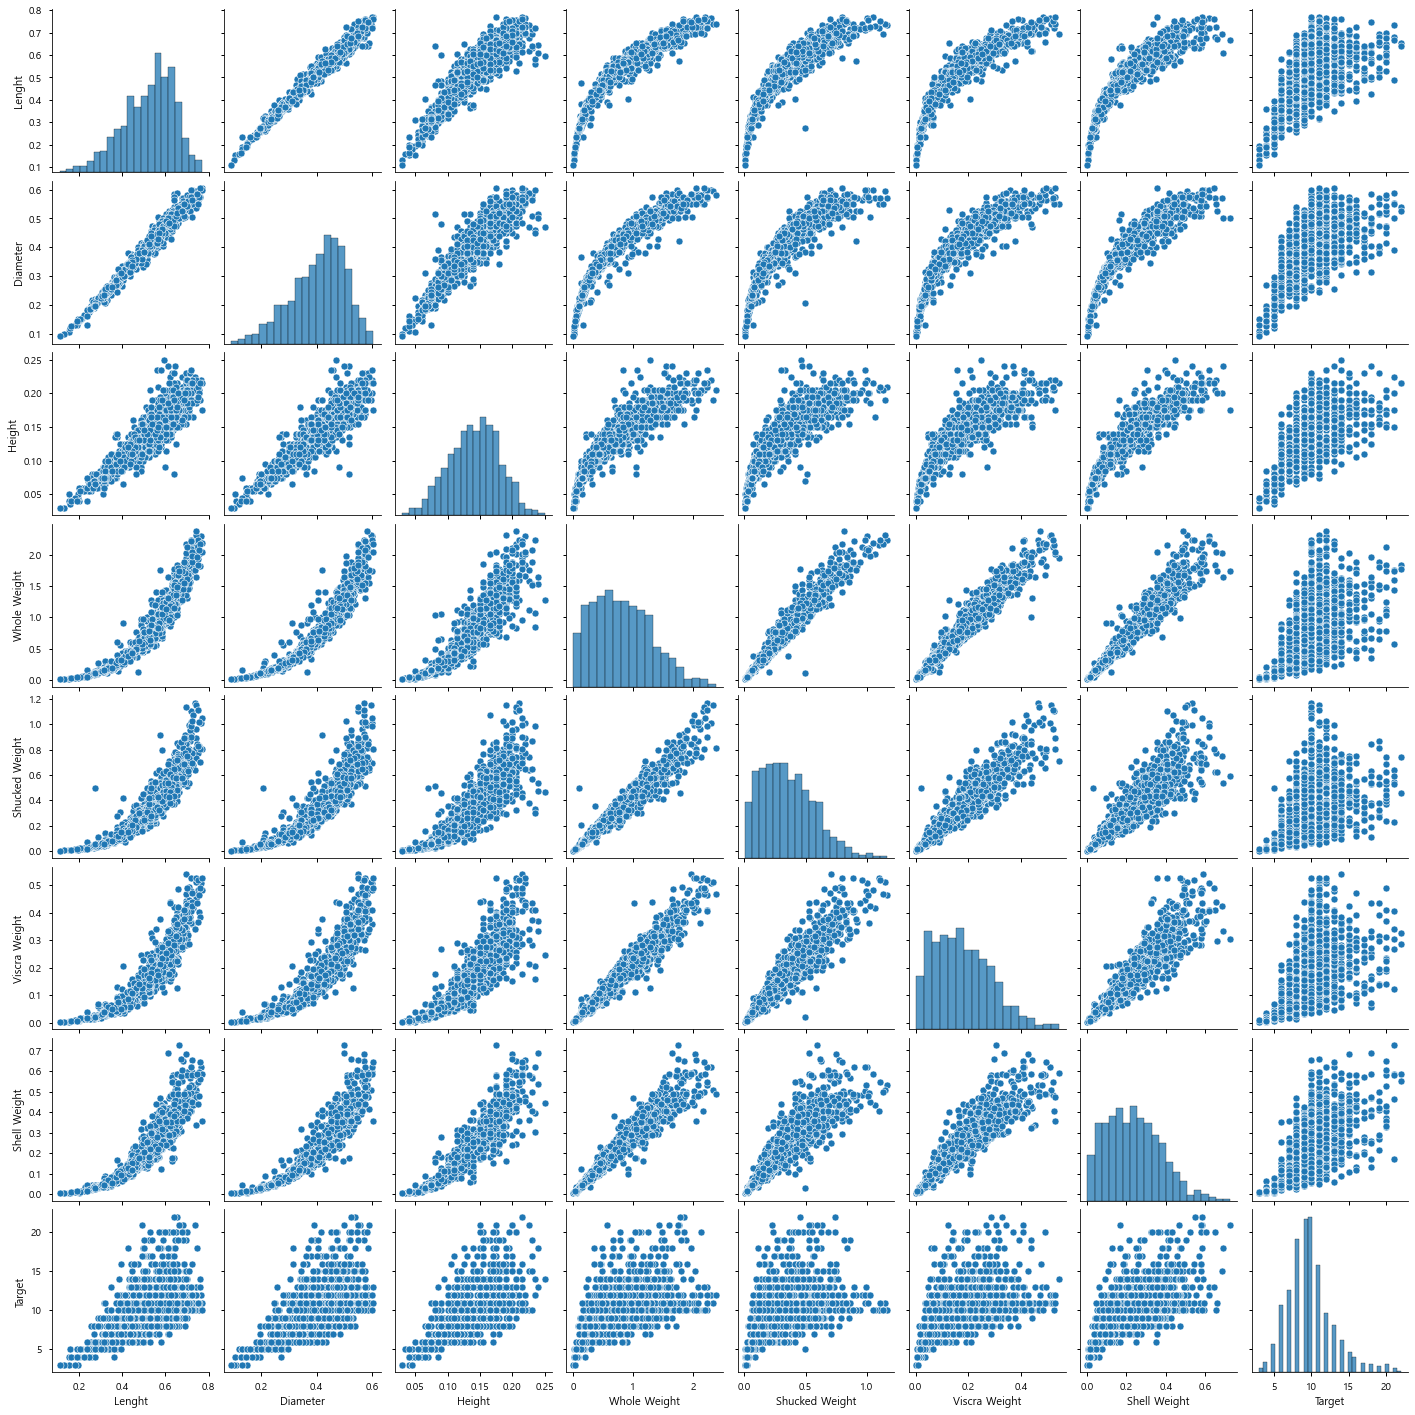

In [294]:
sns.pairplot(train)

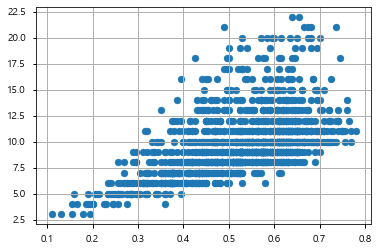

In [289]:
# Lenght
var = 'Lenght'
plt.scatter(x = train[var], y = train['Target'],)
plt.grid(True)

In [288]:
train.drop(train[(train['Lenght']> 0.6) & (train['Target'] > 25)].index, inplace=True)
train.drop(train[(train['Lenght']> 0.4) & (train['Target'] > 22.5)].index, inplace=True)
#train.drop(train[(train['Lenght']> 0.4) & (train['Target'] > 20)].index, inplace=True)

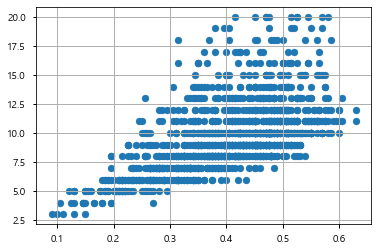

In [239]:
# Diameter
var = 'Diameter'
plt.scatter(x = train[var], y = train['Target'],)
plt.grid(True)

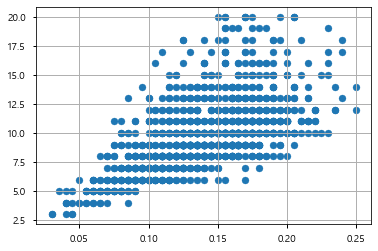

In [240]:
# Height
var = 'Height'
plt.scatter(x = train[var], y = train['Target'],)
plt.grid(True)

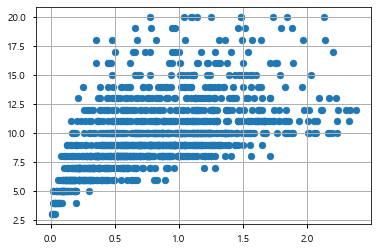

In [243]:
# Whole Weight
var = 'Whole Weight'
plt.scatter(x = train[var], y = train['Target'],)
plt.grid(True)

In [242]:
train.drop(train[(train['Whole Weight']> 2.5) & (train['Target'] < 12.5)].index, inplace=True)

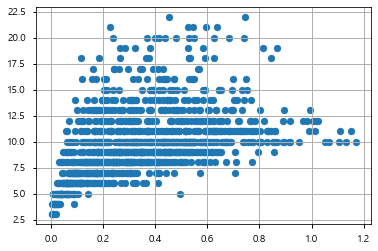

In [293]:
# Shucked Weight
var = 'Shucked Weight'
plt.scatter(x = train[var], y = train['Target'],)
plt.grid(True)

In [292]:
train.drop(train[(train['Shucked Weight']> 1.2) & (train['Target'] < 12.5)].index, inplace=True)
#train.drop(train[(train['Shucked Weight']> 1.0) & (train['Target'] < 12.5)].index, inplace=True)
#train.drop(train[(train['Shucked Weight']> 0) & (train['Target'] > 17.5)].index, inplace=True)

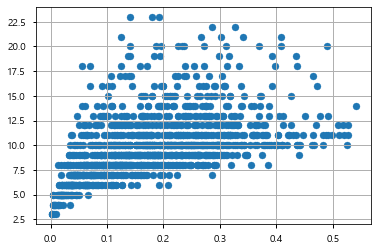

In [281]:
# Viscra Weight	
var = 'Viscra Weight'
plt.scatter(x = train[var], y = train['Target'],)
plt.grid(True)

In [280]:
train.drop(train[(train['Viscra Weight']> 0.6) & (train['Target'] < 12.5)].index, inplace=True)

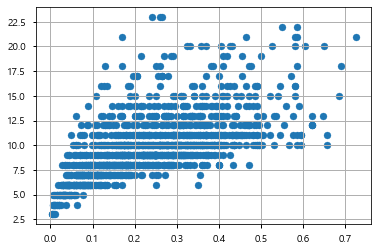

In [285]:
# Shell Weight
var = 'Shell Weight'
plt.scatter(x = train[var], y = train['Target'],)
plt.grid(True)

In [284]:
train.drop(train[(train['Shell Weight']> 0.8) & (train['Target'] > 15.0)].index, inplace=True)

In [295]:
train

,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
0,M,0.605,0.470,0.115,1.1140,0.3925,0.2910,0.3100,15
1,I,0.430,0.315,0.095,0.3780,0.1750,0.0800,0.1045,8
2,I,0.580,0.490,0.195,1.3165,0.5305,0.2540,0.4100,18
3,M,0.535,0.405,0.175,1.2705,0.5480,0.3265,0.3370,13
4,I,0.310,0.235,0.090,0.1270,0.0480,0.0310,0.0400,6
...,...,...,...,...,...,...,...,...,...
1248,I,0.190,0.145,0.040,0.0380,0.0165,0.0065,0.0150,4
1249,I,0.395,0.310,0.085,0.3170,0.1530,0.0505,0.0935,7
1250,F,0.525,0.410,0.115,0.7745,0.4160,0.1630,0.1800,7
1251,F,0.445,0.335,0.110,0.4355,0.2025,0.1095,0.1195,6


In [296]:
train_X = train.drop('Target', axis=1)
train_y = train.Target

In [297]:
train_X = pd.get_dummies(data = train_X, columns = ['Gender'], prefix = 'Gender')
test = pd.get_dummies(data = test, columns = ['Gender'], prefix = 'Gender')

In [307]:
# 딥러닝 모델 선언
model = Sequential()
model.add(Dense(16, input_dim=10, activation='elu'))
model.add(Dense(32, activation='elu'))    
model.add(Dense(64, activation='elu'))  
model.add(Dropout(0.5))  
model.add(Dense(32, activation='elu'))
model.add(Dense(16, activation='elu'))
model.add(Dense(1))


model.compile(loss='mean_absolute_error',
              optimizer='adam', 
              metrics=['mae'])

In [308]:
# 모델 저장 폴더 만들기
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = "./model/{epoch:02d}-{val_loss:.4f}.hdf5"

# 모델 업데이트 및 저장
cp = ModelCheckpoint(filepath=modelpath, monitor='val_mae', verbose=0, save_best_only=True, mode = 'min')

# 학습 자동 중단 설정
es = EarlyStopping(monitor='val_mae', patience=50, mode='min')

rlrp = ReduceLROnPlateau(monitor='val_mae', factor=0.2, patience=45, mode='min')

In [309]:
# 모델 학습
model.fit(train_X, train_y, validation_split=0.3, epochs=1000, batch_size=32, verbose=1, callbacks=[es, cp, rlrp])

Epoch 1/1000
28/28 [==============================] - 0s 4ms/step - loss: 8.6668 - mae: 8.6668 - val_loss: 6.5145 - val_mae: 6.5145
Epoch 2/1000
28/28 [==============================] - 0s 2ms/step - loss: 3.8240 - mae: 3.8240 - val_loss: 2.2334 - val_mae: 2.2334
Epoch 3/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.9382 - mae: 1.9382 - val_loss: 1.8683 - val_mae: 1.8683
Epoch 4/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.8288 - mae: 1.8288 - val_loss: 1.8671 - val_mae: 1.8671
Epoch 5/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.7600 - mae: 1.7600 - val_loss: 1.8452 - val_mae: 1.8452
Epoch 6/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.7698 - mae: 1.7698 - val_loss: 1.8548 - val_mae: 1.8548
Epoch 7/1000
28/28 [==============================] - 0s 1ms/step - loss: 1.7427 - mae: 1.7427 - val_loss: 1.8443 - val_mae: 1.8443
Epoch 8/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.

28/28 [==============================] - 0s 1ms/step - loss: 1.4374 - mae: 1.4374 - val_loss: 1.5602 - val_mae: 1.5602
Epoch 124/1000
28/28 [==============================] - 0s 1ms/step - loss: 1.4452 - mae: 1.4452 - val_loss: 1.5598 - val_mae: 1.5598
Epoch 125/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4473 - mae: 1.4473 - val_loss: 1.5504 - val_mae: 1.5504
Epoch 126/1000
28/28 [==============================] - 0s 1ms/step - loss: 1.4733 - mae: 1.4733 - val_loss: 1.5607 - val_mae: 1.5607
Epoch 127/1000
28/28 [==============================] - 0s 1ms/step - loss: 1.4347 - mae: 1.4347 - val_loss: 1.5589 - val_mae: 1.5589
Epoch 128/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4689 - mae: 1.4689 - val_loss: 1.6365 - val_mae: 1.6365
Epoch 129/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4830 - mae: 1.4830 - val_loss: 1.6778 - val_mae: 1.6778
Epoch 130/1000
28/28 [==============================] - 0s 2ms/step - loss: 1

28/28 [==============================] - 0s 1ms/step - loss: 1.3853 - mae: 1.3853 - val_loss: 1.4865 - val_mae: 1.4865
Epoch 246/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4072 - mae: 1.4072 - val_loss: 1.5132 - val_mae: 1.5132
Epoch 247/1000
28/28 [==============================] - 0s 1ms/step - loss: 1.3987 - mae: 1.3987 - val_loss: 1.4880 - val_mae: 1.4880
Epoch 248/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.3964 - mae: 1.3964 - val_loss: 1.5067 - val_mae: 1.5067
Epoch 249/1000
28/28 [==============================] - 0s 1ms/step - loss: 1.3828 - mae: 1.3828 - val_loss: 1.5069 - val_mae: 1.5069
Epoch 250/1000
28/28 [==============================] - 0s 1ms/step - loss: 1.3784 - mae: 1.3784 - val_loss: 1.5000 - val_mae: 1.5000
Epoch 251/1000
28/28 [==============================] - 0s 1ms/step - loss: 1.3950 - mae: 1.3950 - val_loss: 1.4942 - val_mae: 1.4942
Epoch 252/1000
28/28 [==============================] - 0s 1ms/step - loss: 1

In [305]:
Y_prediction = model.predict(test).flatten()

In [306]:
Y_prediction

array([ 9.477407, 14.252874,  5.288475, ...,  9.170164,  8.542906,
       12.24073 ], dtype=float32)

In [310]:
submission = pd.read_csv('sample_submission.csv')

submission['Target'] = Y_prediction

submission

submission.to_csv('submission.csv',index=False)

# 피쳐 추가 2

In [255]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

train_X = train.drop('Target', axis=1)
train_y = train.Target

In [256]:
train_X = pd.get_dummies(data = train_X, columns = ['Gender'], prefix = 'Gender')
test = pd.get_dummies(data = test, columns = ['Gender'], prefix = 'Gender')

In [257]:
train_X

,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Gender_F,Gender_I,Gender_M
0,0.605,0.470,0.115,1.1140,0.3925,0.2910,0.3100,0,0,1
1,0.430,0.315,0.095,0.3780,0.1750,0.0800,0.1045,0,1,0
2,0.580,0.490,0.195,1.3165,0.5305,0.2540,0.4100,0,1,0
3,0.535,0.405,0.175,1.2705,0.5480,0.3265,0.3370,0,0,1
4,0.310,0.235,0.090,0.1270,0.0480,0.0310,0.0400,0,1,0
...,...,...,...,...,...,...,...,...,...,...
1248,0.190,0.145,0.040,0.0380,0.0165,0.0065,0.0150,0,1,0
1249,0.395,0.310,0.085,0.3170,0.1530,0.0505,0.0935,0,1,0
1250,0.525,0.410,0.115,0.7745,0.4160,0.1630,0.1800,1,0,0
1251,0.445,0.335,0.110,0.4355,0.2025,0.1095,0.1195,1,0,0


In [326]:
# 전복 전체 무게 대비 불필요한 물질들의 값 ( 이물질 / 핏물 등)
foreign_body = train_X['Whole Weight'] - (train_X['Shucked Weight'] + train_X['Viscra Weight'] + train_X['Shell Weight'])
train_X['foreign body'] = foreign_body
train_X.loc[train_X['foreign body'] < 0 , 'foreign body'] = 0

In [327]:
# 테스트셋에도 적용
foreign_body = test['Whole Weight'] - (test['Shucked Weight'] + test['Viscra Weight'] + test['Shell Weight'])
test['foreign body'] = foreign_body
test.loc[test['foreign body'] < 0 , 'foreign body'] = 0

In [181]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

In [343]:
# 딥러닝 모델 선언
model = Sequential()
model.add(Dense(16, input_dim=len(train_X.columns), activation='elu'))
model.add(Dense(32, activation='elu'))    
model.add(Dense(64, activation='elu'))  
model.add(Dropout(0.5))  
model.add(Dense(32, activation='elu'))
model.add(Dense(16, activation='elu'))
model.add(Dense(1))


model.compile(loss='mean_absolute_error',
              optimizer='Nadam', 
              metrics=['mae'])

# 모델 저장 폴더 만들기
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = "./model/{epoch:02d}-{val_loss:.4f}.hdf5"

# 모델 업데이트 및 저장
cp = ModelCheckpoint(filepath=modelpath, monitor='val_mae', verbose=0, save_best_only=True, mode = 'min')

# 학습 자동 중단 설정
es = EarlyStopping(monitor='val_mae', patience=50, mode='min')

rlrp = ReduceLROnPlateau(monitor='val_mae', factor=0.2, patience=40, mode='min')

# 모델 학습
history = model.fit(train_X, train_y, validation_split=0.33, epochs=1000, batch_size=32, verbose=1, callbacks=[es, cp, rlrp])

Epoch 1/1000
27/27 [==============================] - 1s 6ms/step - loss: 8.3510 - mae: 8.3510 - val_loss: 4.7812 - val_mae: 4.7812 - lr: 0.0010
Epoch 2/1000
27/27 [==============================] - 0s 3ms/step - loss: 2.6413 - mae: 2.6413 - val_loss: 2.0623 - val_mae: 2.0623 - lr: 0.0010
Epoch 3/1000
27/27 [==============================] - 0s 3ms/step - loss: 2.0287 - mae: 2.0287 - val_loss: 1.9549 - val_mae: 1.9549 - lr: 0.0010
Epoch 4/1000
27/27 [==============================] - 0s 3ms/step - loss: 1.8856 - mae: 1.8856 - val_loss: 1.9041 - val_mae: 1.9041 - lr: 0.0010
Epoch 5/1000
27/27 [==============================] - 0s 3ms/step - loss: 1.8435 - mae: 1.8435 - val_loss: 1.8869 - val_mae: 1.8869 - lr: 0.0010
Epoch 6/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.8793 - mae: 1.8793 - val_loss: 1.9289 - val_mae: 1.9289 - lr: 0.0010
Epoch 7/1000
27/27 [==============================] - 0s 3ms/step - loss: 1.8326 - mae: 1.8326 - val_loss: 1.8700 - val_mae: 1.870

27/27 [==============================] - 0s 2ms/step - loss: 1.5421 - mae: 1.5421 - val_loss: 1.6485 - val_mae: 1.6485 - lr: 0.0010
Epoch 58/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.5379 - mae: 1.5379 - val_loss: 1.7206 - val_mae: 1.7206 - lr: 0.0010
Epoch 59/1000
27/27 [==============================] - 0s 3ms/step - loss: 1.5414 - mae: 1.5414 - val_loss: 1.6248 - val_mae: 1.6248 - lr: 0.0010
Epoch 60/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.5392 - mae: 1.5392 - val_loss: 1.6278 - val_mae: 1.6278 - lr: 0.0010
Epoch 61/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.5307 - mae: 1.5307 - val_loss: 1.6170 - val_mae: 1.6170 - lr: 0.0010
Epoch 62/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.4968 - mae: 1.4968 - val_loss: 1.6418 - val_mae: 1.6418 - lr: 0.0010
Epoch 63/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.5037 - mae: 1.5037 - val_loss: 1.6070 - val_mae: 1.6070 - lr:

27/27 [==============================] - 0s 2ms/step - loss: 1.4459 - mae: 1.4459 - val_loss: 1.6117 - val_mae: 1.6117 - lr: 0.0010
Epoch 114/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.4751 - mae: 1.4751 - val_loss: 1.5243 - val_mae: 1.5243 - lr: 0.0010
Epoch 115/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.4747 - mae: 1.4747 - val_loss: 1.5386 - val_mae: 1.5386 - lr: 0.0010
Epoch 116/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.4552 - mae: 1.4552 - val_loss: 1.5472 - val_mae: 1.5472 - lr: 0.0010
Epoch 117/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.4663 - mae: 1.4663 - val_loss: 1.5322 - val_mae: 1.5322 - lr: 0.0010
Epoch 118/1000
27/27 [==============================] - 0s 3ms/step - loss: 1.4629 - mae: 1.4629 - val_loss: 1.5809 - val_mae: 1.5809 - lr: 0.0010
Epoch 119/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.4398 - mae: 1.4398 - val_loss: 1.5447 - val_mae: 1.5447

Epoch 169/1000
27/27 [==============================] - 0s 3ms/step - loss: 1.4278 - mae: 1.4278 - val_loss: 1.5031 - val_mae: 1.5031 - lr: 0.0010
Epoch 170/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.4188 - mae: 1.4188 - val_loss: 1.5459 - val_mae: 1.5459 - lr: 0.0010
Epoch 171/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.4074 - mae: 1.4074 - val_loss: 1.5290 - val_mae: 1.5290 - lr: 0.0010
Epoch 172/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.4332 - mae: 1.4332 - val_loss: 1.5188 - val_mae: 1.5188 - lr: 0.0010
Epoch 173/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.4366 - mae: 1.4366 - val_loss: 1.5397 - val_mae: 1.5397 - lr: 0.0010
Epoch 174/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.4364 - mae: 1.4364 - val_loss: 1.5331 - val_mae: 1.5331 - lr: 0.0010
Epoch 175/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.4283 - mae: 1.4283 - val_loss: 1.5198 - 

Epoch 225/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.3922 - mae: 1.3922 - val_loss: 1.5040 - val_mae: 1.5040 - lr: 2.0000e-04
Epoch 226/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.3933 - mae: 1.3933 - val_loss: 1.5046 - val_mae: 1.5046 - lr: 2.0000e-04
Epoch 227/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.3928 - mae: 1.3928 - val_loss: 1.5041 - val_mae: 1.5041 - lr: 2.0000e-04
Epoch 228/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.3856 - mae: 1.3856 - val_loss: 1.5102 - val_mae: 1.5102 - lr: 2.0000e-04
Epoch 229/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.4066 - mae: 1.4066 - val_loss: 1.5040 - val_mae: 1.5040 - lr: 2.0000e-04
Epoch 230/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.4021 - mae: 1.4021 - val_loss: 1.5039 - val_mae: 1.5039 - lr: 2.0000e-04
Epoch 231/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.4049 - mae: 1.40

In [344]:
history.history['val_loss'][np.argmin(history.history['val_loss'])]

1.4991919994354248

In [345]:
Y_prediction = model.predict(test).flatten()

In [346]:
Y_prediction

array([10.204909, 14.853247,  5.302126, ...,  9.181011,  8.657111,
       11.829182], dtype=float32)

In [347]:
submission = pd.read_csv('sample_submission.csv')

submission['Target'] = np.round(Y_prediction)

submission

submission.to_csv('submission0.33_1.4992_0처리.csv',index=False)

## MinMax scaler

In [216]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

train_X = train.drop('Target', axis=1)
train_y = train.Target

In [217]:
train_X = pd.get_dummies(data = train_X, columns = ['Gender'], prefix = 'Gender')
test = pd.get_dummies(data = test, columns = ['Gender'], prefix = 'Gender')

In [218]:
train_X

,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Gender_F,Gender_I,Gender_M
0,0.605,0.470,0.115,1.1140,0.3925,0.2910,0.3100,0,0,1
1,0.430,0.315,0.095,0.3780,0.1750,0.0800,0.1045,0,1,0
2,0.580,0.490,0.195,1.3165,0.5305,0.2540,0.4100,0,1,0
3,0.535,0.405,0.175,1.2705,0.5480,0.3265,0.3370,0,0,1
4,0.310,0.235,0.090,0.1270,0.0480,0.0310,0.0400,0,1,0
...,...,...,...,...,...,...,...,...,...,...
1248,0.190,0.145,0.040,0.0380,0.0165,0.0065,0.0150,0,1,0
1249,0.395,0.310,0.085,0.3170,0.1530,0.0505,0.0935,0,1,0
1250,0.525,0.410,0.115,0.7745,0.4160,0.1630,0.1800,1,0,0
1251,0.445,0.335,0.110,0.4355,0.2025,0.1095,0.1195,1,0,0


In [219]:
var = ['Lenght','Diameter','Height','Whole Weight','Shucked Weight','Viscra Weight','Shell Weight']

In [220]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(train_X[var])  # 데이터프레임이 되어버림

train_X[var] = scaler.transform(train_X[var])


train_X

,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Gender_F,Gender_I,Gender_M
0,0.738806,0.703704,0.386364,0.399062,0.262538,0.381266,0.306387,0,0,1
1,0.477612,0.416667,0.295455,0.133502,0.116123,0.102902,0.101297,0,1,0
2,0.701493,0.740741,0.750000,0.472127,0.355436,0.332454,0.406188,0,1,0
3,0.634328,0.583333,0.659091,0.455529,0.367216,0.428100,0.333333,0,0,1
4,0.298507,0.268519,0.272727,0.042937,0.030629,0.038259,0.036926,0,1,0
...,...,...,...,...,...,...,...,...,...,...
1248,0.119403,0.101852,0.045455,0.010824,0.009424,0.005937,0.011976,0,1,0
1249,0.425373,0.407407,0.250000,0.111492,0.101313,0.063984,0.090319,0,1,0
1250,0.619403,0.592593,0.386364,0.276565,0.278357,0.212401,0.176647,1,0,0
1251,0.500000,0.453704,0.363636,0.154249,0.134635,0.141821,0.116267,1,0,0


In [232]:
test[var] = scaler.transform(test[var])

In [241]:
# 전복 전체 무게 대비 불필요한 물질들의 값 ( 이물질 / 핏물 등)
foreign_body = train_X['Whole Weight'] - (train_X['Shucked Weight'] + train_X['Viscra Weight'] + train_X['Shell Weight'])
train_X['foreign body'] = foreign_body
#train_X.loc[train_X['foreign body'] < 0 , 'foreign body'] = 0

In [242]:
# 테스트셋에도 적용
foreign_body = test['Whole Weight'] - (test['Shucked Weight'] + test['Viscra Weight'] + test['Shell Weight'])
test['foreign body'] = foreign_body
#test.loc[test['foreign body'] < 0 , 'foreign body'] = 0

In [249]:
# 딥러닝 모델 선언
model = Sequential()
model.add(Dense(16, input_dim=len(train_X.columns), activation='elu'))
model.add(Dense(32, activation='elu'))    
model.add(Dense(64, activation='elu'))  
model.add(Dropout(0.5))  
model.add(Dense(32, activation='elu'))
model.add(Dense(16, activation='elu'))
model.add(Dense(1))


model.compile(loss='mean_absolute_error',
              optimizer='Nadam', 
              metrics=['mae'])

In [250]:
# 모델 저장 폴더 만들기
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = "./model/{epoch:02d}-{val_loss:.4f}.hdf5"

# 모델 업데이트 및 저장
cp = ModelCheckpoint(filepath=modelpath, monitor='val_mae', verbose=0, save_best_only=True, mode = 'min')

# 학습 자동 중단 설정
es = EarlyStopping(monitor='val_mae', patience=50, mode='min')

rlrp = ReduceLROnPlateau(monitor='val_mae', factor=0.2, patience=40, mode='min')

In [251]:
# 모델 학습
model.fit(train_X, train_y, validation_split=0.3, epochs=1000, batch_size=32, verbose=1, callbacks=[es, cp, rlrp])

Epoch 1/1000
28/28 [==============================] - 1s 5ms/step - loss: 7.0810 - mae: 7.0810 - val_loss: 1.9952 - val_mae: 1.9952 - lr: 0.0010
Epoch 2/1000
28/28 [==============================] - 0s 3ms/step - loss: 2.0266 - mae: 2.0266 - val_loss: 1.9362 - val_mae: 1.9362 - lr: 0.0010
Epoch 3/1000
28/28 [==============================] - 0s 3ms/step - loss: 2.0284 - mae: 2.0284 - val_loss: 1.9252 - val_mae: 1.9252 - lr: 0.0010
Epoch 4/1000
28/28 [==============================] - 0s 3ms/step - loss: 1.9414 - mae: 1.9414 - val_loss: 1.9185 - val_mae: 1.9185 - lr: 0.0010
Epoch 5/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.9252 - mae: 1.9252 - val_loss: 1.9373 - val_mae: 1.9373 - lr: 0.0010
Epoch 6/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.8691 - mae: 1.8691 - val_loss: 1.9211 - val_mae: 1.9211 - lr: 0.0010
Epoch 7/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.8195 - mae: 1.8195 - val_loss: 1.9230 - val_mae: 1.923

28/28 [==============================] - 0s 2ms/step - loss: 1.5354 - mae: 1.5354 - val_loss: 1.6827 - val_mae: 1.6827 - lr: 0.0010
Epoch 58/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.5745 - mae: 1.5745 - val_loss: 1.7331 - val_mae: 1.7331 - lr: 0.0010
Epoch 59/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.5194 - mae: 1.5194 - val_loss: 1.6945 - val_mae: 1.6945 - lr: 0.0010
Epoch 60/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.5512 - mae: 1.5512 - val_loss: 1.7028 - val_mae: 1.7028 - lr: 0.0010
Epoch 61/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.5395 - mae: 1.5395 - val_loss: 1.7381 - val_mae: 1.7381 - lr: 0.0010
Epoch 62/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.5405 - mae: 1.5405 - val_loss: 1.6788 - val_mae: 1.6788 - lr: 0.0010
Epoch 63/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.5145 - mae: 1.5145 - val_loss: 1.6956 - val_mae: 1.6956 - lr:

28/28 [==============================] - 0s 2ms/step - loss: 1.4820 - mae: 1.4820 - val_loss: 1.6557 - val_mae: 1.6557 - lr: 0.0010
Epoch 114/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4851 - mae: 1.4851 - val_loss: 1.6562 - val_mae: 1.6562 - lr: 0.0010
Epoch 115/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4892 - mae: 1.4892 - val_loss: 1.6619 - val_mae: 1.6619 - lr: 0.0010
Epoch 116/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4978 - mae: 1.4978 - val_loss: 1.6478 - val_mae: 1.6478 - lr: 0.0010
Epoch 117/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4861 - mae: 1.4861 - val_loss: 1.6684 - val_mae: 1.6684 - lr: 0.0010
Epoch 118/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4944 - mae: 1.4944 - val_loss: 1.6536 - val_mae: 1.6536 - lr: 0.0010
Epoch 119/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4917 - mae: 1.4917 - val_loss: 1.6973 - val_mae: 1.6973

Epoch 169/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4419 - mae: 1.4419 - val_loss: 1.6481 - val_mae: 1.6481 - lr: 0.0010
Epoch 170/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4629 - mae: 1.4629 - val_loss: 1.6064 - val_mae: 1.6064 - lr: 0.0010
Epoch 171/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4667 - mae: 1.4667 - val_loss: 1.6132 - val_mae: 1.6132 - lr: 0.0010
Epoch 172/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4418 - mae: 1.4418 - val_loss: 1.6022 - val_mae: 1.6022 - lr: 0.0010
Epoch 173/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4376 - mae: 1.4376 - val_loss: 1.5866 - val_mae: 1.5866 - lr: 0.0010
Epoch 174/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4454 - mae: 1.4454 - val_loss: 1.5976 - val_mae: 1.5976 - lr: 0.0010
Epoch 175/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4546 - mae: 1.4546 - val_loss: 1.5881 - 

Epoch 225/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4081 - mae: 1.4081 - val_loss: 1.5982 - val_mae: 1.5982 - lr: 0.0010
Epoch 226/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4213 - mae: 1.4213 - val_loss: 1.6320 - val_mae: 1.6320 - lr: 0.0010
Epoch 227/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4278 - mae: 1.4278 - val_loss: 1.5538 - val_mae: 1.5538 - lr: 0.0010
Epoch 228/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4143 - mae: 1.4143 - val_loss: 1.5898 - val_mae: 1.5898 - lr: 0.0010
Epoch 229/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4485 - mae: 1.4485 - val_loss: 1.5642 - val_mae: 1.5642 - lr: 0.0010
Epoch 230/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4396 - mae: 1.4396 - val_loss: 1.5637 - val_mae: 1.5637 - lr: 0.0010
Epoch 231/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4181 - mae: 1.4181 - val_loss: 1.6281 - 

Epoch 281/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4092 - mae: 1.4092 - val_loss: 1.5966 - val_mae: 1.5966 - lr: 0.0010
Epoch 282/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.3964 - mae: 1.3964 - val_loss: 1.5871 - val_mae: 1.5871 - lr: 0.0010
Epoch 283/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4360 - mae: 1.4360 - val_loss: 1.5613 - val_mae: 1.5613 - lr: 0.0010
Epoch 284/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4343 - mae: 1.4343 - val_loss: 1.5618 - val_mae: 1.5618 - lr: 0.0010
Epoch 285/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.3995 - mae: 1.3995 - val_loss: 1.5673 - val_mae: 1.5673 - lr: 0.0010
Epoch 286/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4119 - mae: 1.4119 - val_loss: 1.5783 - val_mae: 1.5783 - lr: 0.0010
Epoch 287/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4020 - mae: 1.4020 - val_loss: 1.5879 - 

Epoch 337/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4101 - mae: 1.4101 - val_loss: 1.5285 - val_mae: 1.5285 - lr: 0.0010
Epoch 338/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.3973 - mae: 1.3973 - val_loss: 1.5625 - val_mae: 1.5625 - lr: 0.0010
Epoch 339/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4295 - mae: 1.4295 - val_loss: 1.5562 - val_mae: 1.5562 - lr: 0.0010
Epoch 340/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4189 - mae: 1.4189 - val_loss: 1.5414 - val_mae: 1.5414 - lr: 0.0010
Epoch 341/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4331 - mae: 1.4331 - val_loss: 1.5473 - val_mae: 1.5473 - lr: 0.0010
Epoch 342/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4175 - mae: 1.4175 - val_loss: 1.5423 - val_mae: 1.5423 - lr: 0.0010
Epoch 343/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4088 - mae: 1.4088 - val_loss: 1.5347 - 

Epoch 393/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.3975 - mae: 1.3975 - val_loss: 1.5337 - val_mae: 1.5337 - lr: 0.0010
Epoch 394/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.3989 - mae: 1.3989 - val_loss: 1.5293 - val_mae: 1.5293 - lr: 0.0010
Epoch 395/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4049 - mae: 1.4049 - val_loss: 1.5329 - val_mae: 1.5329 - lr: 0.0010
Epoch 396/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.3865 - mae: 1.3865 - val_loss: 1.5566 - val_mae: 1.5566 - lr: 0.0010
Epoch 397/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.3897 - mae: 1.3897 - val_loss: 1.5416 - val_mae: 1.5416 - lr: 0.0010
Epoch 398/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.4014 - mae: 1.4014 - val_loss: 1.5422 - val_mae: 1.5422 - lr: 0.0010
Epoch 399/1000
28/28 [==============================] - 0s 2ms/step - loss: 1.3970 - mae: 1.3970 - val_loss: 1.5274 - 

In [252]:
Y_prediction = model.predict(test).flatten()

In [253]:
Y_prediction

array([ 9.01175  , 14.216919 ,  5.3847127, ...,  9.154172 ,  8.233047 ,
       11.970468 ], dtype=float32)

In [254]:
submission = pd.read_csv('sample_submission.csv')

submission['Target'] = np.round(Y_prediction)

submission

submission.to_csv('submission.csv',index=False)